In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import country_converter as coco
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial.distance import squareform, pdist
from geopy.distance import geodesic
from math import isclose
from src.preprocessing import main as preprocessing_main
from src.utils import plot_winkel_tripel_map, prepare_centroids


In [2]:
print(os.getcwd())
# Go up one directory to get to the data folder
data_dir = os.path.join(os.path.dirname(os.getcwd()))
os.chdir(data_dir)
print(os.getcwd())

/home/florian/Documents/GitHub/pytradeshifts/scripts
/home/florian/Documents/GitHub/pytradeshifts


In [3]:
hedlund_excel = pd.read_excel(
    "."
    + os.sep
    + "data"
    + os.sep
    + "validation_data_from_Hedlung_2022"
    + os.sep
    + "Ex_15_third percentile_climate impacts.xlsx",
    sheet_name="adding climate impacts",
    engine="openpyxl",
    usecols="A:DI",
    index_col=0,
)

# Sort index and columns
hedlund_excel.sort_index(inplace=True)
hedlund_excel.sort_index(axis=1, inplace=True)

print(hedlund_excel.shape)

# Rename countries using country_converter
hedlund_excel.index = coco.convert(names=hedlund_excel.index, to="name_short")
hedlund_excel.columns = coco.convert(names=hedlund_excel.columns, to="name_short")

# drop all nan rows and columns
hedlund_excel.dropna(axis=0, how="all", inplace=True)
print(hedlund_excel.shape)


hedlund_excel.head(-5)


(239, 112)
(112, 112)


,Afghanistan,Albania,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bangladesh,Belarus,...,Ukraine,United Kingdom,Tanzania,United States,Uruguay,Uzbekistan,Vietnam,Yemen,Zambia,Zimbabwe
Afghanistan,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0
Albania,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0
Algeria,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0
Argentina,0.0,0.0,1.301639e+06,0.0,0.0,0.0,0.0000,0.0,246454.7244,0.0000,...,0.0,0.0000,0.0000,423.3401,429.6583,0.0,217188.8207,0.0000,0.0,0.0
Armenia,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,0.0,0.0,3.070243e+04,0.0,0.0,0.0,3519.3989,0.0,914368.6285,796.2703,...,0.0,41652.0082,39969.3461,0.0000,0.0000,0.0,0.0000,519495.1914,0.0,0.0
United Kingdom,0.0,0.0,1.759174e+02,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0
Tanzania,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0
United States,0.0,0.0,4.122007e+05,0.0,0.0,0.0,0.0000,0.0,425467.6889,0.0000,...,0.0,120604.1189,11478.7514,0.0000,0.0000,0.0,263800.4671,452816.9197,0.0,0.0


In [4]:
trade_graph = nx.from_pandas_adjacency(
            hedlund_excel, create_using=nx.DiGraph
        )

In [5]:
# Find the lovain community
trade_communities = nx.community.louvain_communities(trade_graph)

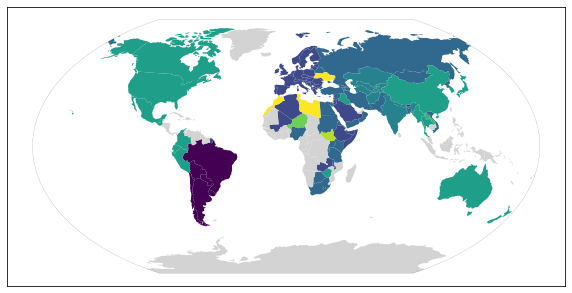

In [6]:
# get the world map
world = gpd.read_file(
    "."
    + os.sep
    + "data"
    + os.sep
    + "geospatial_references"
    + os.sep
    + "ne_110m_admin_0_countries"
    + os.sep
    + "ne_110m_admin_0_countries.shp"
)
world = world.to_crs("+proj=wintri")  # Change projection to Winkel Tripel

# Create a dictionary with the countries and which community they belong to
# The communities are numbered from 0 to n
country_community = {}
for i, community in enumerate(trade_communities):
    for country in community:
        # Convert to standard short names
        country_community[country] = i

cc = coco.CountryConverter()
world["names_short"] = cc.pandas_convert(
    pd.Series(world["ADMIN"]), to="name_short"
)

# Join the country_community dictionary to the world dataframe
world["community"] = world["names_short"].map(country_community)

# Plot the world map and color the countries according to their community
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(
    ax=ax,
    column="community",
    cmap="viridis",
    missing_kwds={"color": "lightgrey"},
    legend=False,
)

plot_winkel_tripel_map(ax)